In [ ]:
import os
import shutil

os.listdir("/content/drive/MyDrive/custom dataset/training")
os.listdir("/content/drive/MyDrive/custom dataset/validation")

['0', '1']

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

base_model.summary()

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])


from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically

# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/drive/MyDrive/custom dataset/training', 
                                       target_size=(224, 224), 
                                       color_mode='rgb', 
                                       class_mode='binary', 
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('/content/drive/MyDrive/custom dataset/validation', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

h1= model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, workers=10, epochs=20)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

history = model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, workers=10, epochs=8)


Epoch 1/8
12/12 [==============================] - 198s 16s/step - loss: 0.2145 - binary_accuracy: 0.9375 - val_loss: 0.2406 - val_binary_accuracy: 0.9286
Epoch 2/8
12/12 [==============================] - 195s 16s/step - loss: 0.1495 - binary_accuracy: 0.9271 - val_loss: 0.0944 - val_binary_accuracy: 0.9643
Epoch 3/8
12/12 [==============================] - 195s 16s/step - loss: 0.1534 - binary_accuracy: 0.9583 - val_loss: 0.1128 - val_binary_accuracy: 0.9643
Epoch 4/8
12/12 [==============================] - 188s 16s/step - loss: 0.2087 - binary_accuracy: 0.9348 - val_loss: 0.2312 - val_binary_accuracy: 0.9286
Epoch 5/8
12/12 [==============================] - 195s 16s/step - loss: 0.0868 - binary_accuracy: 0.9688 - val_loss: 0.2044 - val_binary_accuracy: 0.9643
Epoch 6/8
12/12 [==============================] - 187s 16s/step - loss: 0.1391 - binary_accuracy: 0.9565 - val_loss: 0.1490 - val_binary_accuracy: 0.9286
Epoch 7/8
12/12 [==============================] - 188s 16s/step - los

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


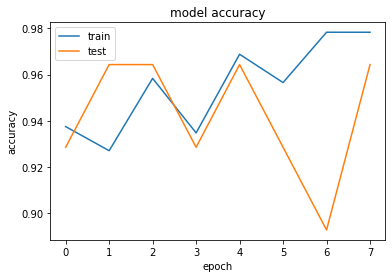

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

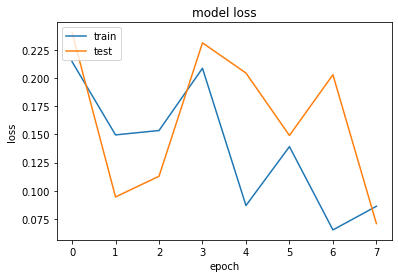

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Examining Predictions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image, batch_size=1)
    return preds

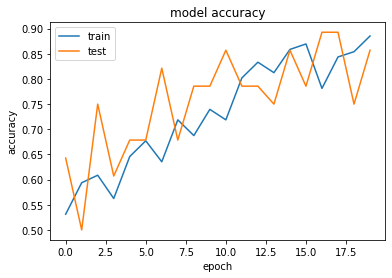

In [ ]:
# summarize history for accuracy
plt.plot(h1.history['binary_accuracy'])
plt.plot(h1.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

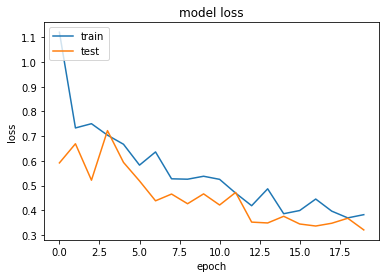

In [ ]:
# summarize history for loss
plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_it = datagen.flow_from_directory('/content/drive/MyDrive/custom dataset/test', 
                                      target_size=(224, 224), 
                                      color_mode='rgb', 
                                      class_mode='binary', 
                                      batch_size=8)

Found 20 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import confusion_matrix
# from plot_conf_matr import plot_confusion_matrix
import numpy as np
category_names=["Accident", "No Accident"]

In [ ]:
Y_pred = model.predict(valid_it)
Y_pred.shape

(20, 1)

In [ ]:
Y_pred

array([[-0.5177838 ],
       [ 0.26690876],
       [-1.1174822 ],
       [-0.68274575],
       [ 2.1797993 ],
       [-2.9433658 ],
       [-1.1028719 ],
       [ 3.867353  ],
       [ 0.03920872],
       [-0.43823224],
       [ 3.2830915 ],
       [-0.2860167 ],
       [ 1.2209172 ],
       [ 3.2399614 ],
       [ 2.644327  ],
       [-1.8805454 ],
       [-1.7720673 ],
       [ 0.26882082],
       [ 0.51731926],
       [ 1.311078  ]], dtype=float32)

In [ ]:
yp=[]
for i in range(0, 20, 1):
  if Y_pred[i]>[0.267]:
    yp.append(1)
  else: 
    yp.append(0)

print(yp)

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]


In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred.shape

(20,)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
test_it.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
# Y_pred = model.predict_generator(valid_it)
# y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(valid_it.classes, yp)
# plot_confusion_matrix(cm)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(cm)

[[8 2]
 [3 7]]


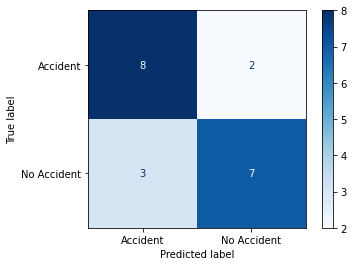

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
labels= ["Accident", "No Accident"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(valid_it.classes, yp)
roc_auc = metrics.auc(fpr, tpr)

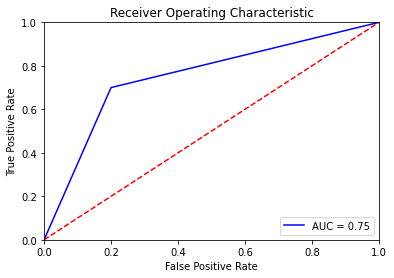

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()